## Does optimization geometry affect how much the sequence prior (ProteinMPNN / LM loss) actually influences the optimization?

In [1]:
import jax
import marimo as mo
import numpy as np
import matplotlib.pyplot as plt
from mosaic.optimizers import (
    simplex_APGM,
    gradient_MCMC,
)
import mosaic.losses.structure_prediction as sp
from mosaic.models.boltz2 import Boltz2
from mosaic.common import TOKENS
from mosaic.losses.transformations import SoftClip
from mosaic.notebook_utils import pdb_viewer
from jaxtyping import Float, Array
from mosaic.common import LossTerm
from mosaic.structure_prediction import TargetChain
from mosaic.models.af2 import AlphaFold2
from mosaic.proteinmpnn.mpnn import ProteinMPNN


[06:31:33] Initializing Normalizer


In [13]:
import os
import urllib.request
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

from Bio.PDB import MMCIFParser, PDBIO, Select
from Bio.PDB.Polypeptide import is_aa
from Bio.SeqUtils import seq1
from Bio.PDB.NeighborSearch import NeighborSearch


RCSB_CIF_URL = "https://files.rcsb.org/download/{pdb_id}.cif"  # Fixed: was {5JDS}


def download_cif(pdb_id: str, out_dir: str = "structures") -> str:
    pdb_id = pdb_id.upper()
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{pdb_id}.cif")
    if not os.path.exists(out_path):
        url = RCSB_CIF_URL.format(pdb_id=pdb_id)
        print(f"Downloading {url}")
        urllib.request.urlretrieve(url, out_path)
    return out_path


def load_structure(cif_path: str, pdb_id: str):
    parser = MMCIFParser(QUIET=True)
    structure = parser.get_structure(pdb_id, cif_path)
    return structure


def chain_sequences_and_lengths(structure) -> Dict[str, Tuple[int, str]]:
    """
    Returns chain_id -> (aa_count, sequence)
    """
    model = next(structure.get_models())
    out = {}
    for chain in model:
        seq = []
        for res in chain:
            if is_aa(res, standard=True):
                try:
                    seq.append(seq1(res.get_resname()))
                except KeyError:
                    # Non-canonical AA
                    pass
        out[chain.id] = (len(seq), "".join(seq))
    return out


class ChainSelect(Select):
    def __init__(self, keep_chain_id: str):
        self.keep = keep_chain_id

    def accept_chain(self, chain):
        return 1 if chain.id == self.keep else 0


def write_chain_pdb(structure, chain_id: str, out_path: str):
    io = PDBIO()
    io.set_structure(structure)
    io.save(out_path, select=ChainSelect(chain_id))
    print(f"Wrote {out_path}")


def get_interface_residues(structure, chain_a: str, chain_b: str, cutoff_angstrom: float = 8.0):
    """
    Returns residue IDs on chain_a that are within cutoff of any atom in chain_b
    and vice versa. Residue IDs are tuples: (chain_id, resseq, icode).
    """
    model = next(structure.get_models())
    A = model[chain_a]
    B = model[chain_b]

    atoms_A = [atom for atom in A.get_atoms() if atom.element != "H"]
    atoms_B = [atom for atom in B.get_atoms() if atom.element != "H"]

    ns = NeighborSearch(atoms_A + atoms_B)

    interface_A = set()
    interface_B = set()

    # For each atom in A, find nearby atoms in B
    for atom in atoms_A:
        close_atoms = ns.search(atom.coord, cutoff_angstrom, level="A")
        for ca in close_atoms:
            if ca.get_parent().get_parent().id == chain_b:
                res = atom.get_parent()
                interface_A.add((chain_a, res.id[1], res.id[2].strip() if isinstance(res.id[2], str) else res.id[2]))

    # For each atom in B, find nearby atoms in A
    for atom in atoms_B:
        close_atoms = ns.search(atom.coord, cutoff_angstrom, level="A")
        for ca in close_atoms:
            if ca.get_parent().get_parent().id == chain_a:
                res = atom.get_parent()
                interface_B.add((chain_b, res.id[1], res.id[2].strip() if isinstance(res.id[2], str) else res.id[2]))

    return sorted(interface_A), sorted(interface_B)


if __name__ == "__main__":
    # ---- Choose a starting complex ----
    # Good starters: "4ZQK" (PD-1/PD-L1), "5JDS" (PD-L1 + nanobody KN035), "5X8L" (PD-L1 + atezolizumab Fab)
    PDB_ID = "4ZQK"

    cif = download_cif(PDB_ID)
    struct = load_structure(cif, PDB_ID)

    info = chain_sequences_and_lengths(struct)
    print(f"\nChains in {PDB_ID}:")
    for cid, (L, seq) in sorted(info.items(), key=lambda x: -x[1][0]):
        print(f"  Chain {cid}: length={L}")

    # ---- Set these after you inspect the chain list above ----
    TARGET_CHAIN = "A"
    BINDER_CHAIN = "B"

    # Write chain-only PDBs
    out_dir = os.path.join("structures", PDB_ID)
    os.makedirs(out_dir, exist_ok=True)
    write_chain_pdb(struct, TARGET_CHAIN, os.path.join(out_dir, f"{PDB_ID}_target_{TARGET_CHAIN}.pdb"))
    write_chain_pdb(struct, BINDER_CHAIN, os.path.join(out_dir, f"{PDB_ID}_binder_{BINDER_CHAIN}.pdb"))

    # Interface residues (optional)
    iface_t, iface_b = get_interface_residues(struct, TARGET_CHAIN, BINDER_CHAIN, cutoff_angstrom=8.0)
    print(f"\nInterface residues within 8Å:")
    print(f"  Target ({TARGET_CHAIN}): n={len(iface_t)}  example={iface_t[:]}")
    print(iface_t,iface_b)
    print(f"  Binder ({BINDER_CHAIN}): n={len(iface_b)}  example={iface_b[:]}")


Chains in 4ZQK:
  Chain A: length=115
  Chain B: length=106
Wrote structures/4ZQK/4ZQK_target_A.pdb
Wrote structures/4ZQK/4ZQK_binder_B.pdb

Interface residues within 8Å:
  Target (A): n=48  example=[('A', 18, ''), ('A', 19, ''), ('A', 20, ''), ('A', 21, ''), ('A', 22, ''), ('A', 23, ''), ('A', 24, ''), ('A', 25, ''), ('A', 26, ''), ('A', 27, ''), ('A', 40, ''), ('A', 52, ''), ('A', 53, ''), ('A', 54, ''), ('A', 55, ''), ('A', 56, ''), ('A', 57, ''), ('A', 58, ''), ('A', 61, ''), ('A', 62, ''), ('A', 63, ''), ('A', 65, ''), ('A', 66, ''), ('A', 67, ''), ('A', 68, ''), ('A', 69, ''), ('A', 73, ''), ('A', 76, ''), ('A', 77, ''), ('A', 111, ''), ('A', 112, ''), ('A', 113, ''), ('A', 114, ''), ('A', 115, ''), ('A', 116, ''), ('A', 117, ''), ('A', 118, ''), ('A', 119, ''), ('A', 120, ''), ('A', 121, ''), ('A', 122, ''), ('A', 123, ''), ('A', 124, ''), ('A', 125, ''), ('A', 126, ''), ('A', 127, ''), ('A', 303, ''), ('A', 304, '')]
[('A', 18, ''), ('A', 19, ''), ('A', 20, ''), ('A', 21, ''),

In [5]:
binder_pdb = "/home/coffeepasta/utkarsh_projects/mosaic/structures/4ZQK/4ZQK_binder_B.pdb"
target_pdb = "/home/coffeepasta/utkarsh_projects/mosaic/structures/4ZQK/4ZQK_target_A.pdb"

In [7]:
import numpy as np
import jax
import jax.numpy as jnp
import gemmi

from mosaic.common import TOKENS
from mosaic.proteinmpnn.mpnn import load_mpnn_sol  # or load_mpnn()
from mosaic.losses.protein_mpnn import load_chain, boltz_to_mpnn_matrix


def prepare_from_separate_pdbs(binder_pdb: str, target_pdb: str):
    import gemmi
    import numpy as np
    import jax
    import jax.numpy as jnp
    from mosaic.common import TOKENS
    from mosaic.losses.protein_mpnn import load_chain

    b = gemmi.read_structure(binder_pdb)
    t = gemmi.read_structure(target_pdb)

    for st in (b, t):
        st.remove_alternative_conformations()
        st.remove_empty_chains()
        try:
            st.remove_ligands_and_waters()
        except Exception:
            pass
        # Clean HOH/HETATM from THIS structure (not just the last one)
        for model in st:
            for chain in model:
                indices_to_delete = [
                    i for i, r in enumerate(chain)
                    if r.het_flag == "H" or r.name in ("HOH", "WAT", "DOD")
                ]
                for i in reversed(indices_to_delete):
                    del chain[i]

    binder_chain = b[0][0]
    target_chain = t[0][0]

    b_seq, b_coords = load_chain(binder_chain)
    t_seq, t_coords = load_chain(target_chain)

    b_len = len(b_seq)
    t_len = len(t_seq)
    total_len = b_len + t_len

    coords = np.concatenate([b_coords, t_coords], axis=0)  # [total_len, 4, 3]

    # Mask positions where backbone atoms are missing
    coord_mask = np.isfinite(coords).all(axis=(-1, -2)).astype(np.int32)
    coords = np.nan_to_num(coords, nan=0.0)

    # Large gap between chains so MPNN treats them separately
    residue_idx = np.concatenate([
        np.arange(1, b_len + 1, dtype=np.int32),
        np.arange(1, t_len + 1, dtype=np.int32) + 200,
    ])

    # 1-indexed chain encoding
    chain_encoding = np.concatenate([
        np.ones(b_len, dtype=np.int32),
        np.full(t_len, 2, dtype=np.int32),
    ])

    full_seq = b_seq + t_seq
    token_ids = np.array(
        [TOKENS.index(aa) if aa in TOKENS else 0 for aa in full_seq],
        dtype=np.int32,
    )
    # Keep as 20-class — sample_empirical_pssm handles the 20->21 conversion internally
    full_seq_20 = jax.nn.one_hot(token_ids, 20, dtype=jnp.float32)  # [total_len, 20]

    return {
        "coords": jnp.array(coords, dtype=jnp.float32),
        "mask": jnp.array(coord_mask, dtype=jnp.int32),
        "residue_idx": jnp.array(residue_idx, dtype=jnp.int32),
        "chain_encoding": jnp.array(chain_encoding, dtype=jnp.int32),
        "full_seq_20": full_seq_20,
        "binder_len": b_len,
        "total_len": total_len,
        "chain_order": ["binder", "target"],
    }



def sample_empirical_pssm(
    mpnn,
    prepared: dict,
    n_samples: int = 512,
    temp: float = 0.2,
    jacobi_iters: int = 8,
    key: jax.Array | None = None,
):
    if key is None:
        key = jax.random.key(0)

    T20_to_21 = jnp.array(boltz_to_mpnn_matrix(), dtype=jnp.float32)
    T21_to_20 = T20_to_21.T

    coords = prepared["coords"]
    mask = prepared["mask"]
    residue_idx = prepared["residue_idx"]
    chain_encoding = prepared["chain_encoding"]
    full_seq_20 = prepared["full_seq_20"]
    binder_len = prepared["binder_len"]
    total_len = prepared["total_len"]

    # Encode structure once
    h_V, h_E, E_idx = mpnn.encode(
        X=coords,
        mask=mask,
        residue_idx=residue_idx,
        chain_encoding_all=chain_encoding,
        key=jax.random.fold_in(key, 1),
    )

    # Start from wildtype binder tokens (can also use random init)
    wt_binder = jnp.argmax(full_seq_20[:binder_len], axis=-1)

    samples = []
    for i in range(n_samples):
        seq = wt_binder
        for t in range(jacobi_iters):
            k = jax.random.fold_in(key, i * 100 + t)

            full_seq = full_seq_20.at[:binder_len].set(jax.nn.one_hot(seq, 20))
            full_seq_21 = full_seq @ T20_to_21

            # Decode binder last (condition on target)
            decoding_order = jax.random.uniform(k, shape=(total_len,)).at[:binder_len].add(2.0)

            log_probs_21 = mpnn.decode(
                S=full_seq_21,
                h_V=h_V,
                h_E=h_E,
                E_idx=E_idx,
                decoding_order=decoding_order,
                mask=mask,
            )[0]  # [N, 21]

            binder_log_probs_20 = log_probs_21[:binder_len] @ T21_to_20  # [binder_len, 20]
            seq = jax.random.categorical(
                jax.random.fold_in(k, 7),
                binder_log_probs_20 / temp,
                axis=-1,
            )

        samples.append(np.array(seq, dtype=np.int32))
        



    samples = np.stack(samples, axis=0)  # [n_samples, binder_len]
    empirical_pssm = jax.nn.one_hot(samples, 20).mean(axis=0)  # [binder_len, 20]
    consensus = "".join(TOKENS[i] for i in np.array(empirical_pssm.argmax(-1)))

    return samples, np.array(empirical_pssm), consensus

def smooth_pssm(pssm, smooth=0.02, eps=1e-6):

    uniform = np.ones_like(pssm) / 20

    p = (1 - smooth) * pssm + smooth * uniform

    p = np.clip(p, eps, 1.0)

    p = p / p.sum(axis=-1, keepdims=True)

    return p

In [8]:
mpnn = load_mpnn_sol()
prepared = prepare_from_separate_pdbs(binder_pdb=binder_pdb,target_pdb=target_pdb)

samples, pssm, consensus = sample_empirical_pssm(
    mpnn,
    prepared,
    n_samples=256,
    temp=0.2,
    jacobi_iters=10,
    key=jax.random.key(230),
)
print("Chain order used:", prepared["chain_order"])
print("Binder length:", prepared["binder_len"])
print("Consensus:", consensus)
pssm = smooth_pssm(pssm)

logits = np.log(pssm)

np.save("binder_samples.npy", samples)

np.save("binder_empirical_pssm.npy", pssm)

np.save("binder_logits_init.npy", logits)

Chain order used: ['binder', 'target']
Binder length: 106
Consensus: PAPTLTPKELTVKEGEDAVFTCTFSTDAEEYVLLWVKLSENGQPVKLASYPGSRFVLTQLPDGTSFDLTIKNAKIDDSGKYKCALIELAPVPRVLESELATLTVTP


In [11]:
data = np.load('binder_empirical_pssm.npy')
print(len(data))

106


## Mask for interface residues <8A° only

In [39]:
iface_binder = [i[1] for i in iface_b if i[1] < binder_len]
mask = np.zeros(binder_len, dtype=bool)
mask[iface_binder] = True
print(mask.shape,mask.sum())

(106,) 23


In [48]:
binder_pdb = "structures/4ZQK/4ZQK_binder_B.pdb"

st = gemmi.read_structure(binder_pdb)
st.setup_entities()  # ensures polymer/non-polymer are correctly assigned
chain = st[0][0]

# get_polymer() returns only the polymer residues (no waters, HETATM ligands)
polymer = chain.get_polymer()

pdb_numbers = [res.seqid.num for res in polymer]

binder_len = len(pdb_numbers)  # should now be exactly 106
print("Binder length from polymer:", binder_len)

pdb_to_index = {pdb_num: i for i, pdb_num in enumerate(pdb_numbers)}

iface_binder_idx = [
    pdb_to_index[i[1]]
    for i in iface_b
    if i[1] in pdb_to_index
]

mask = np.zeros(binder_len, dtype=bool)
mask[iface_binder_idx] = True

print("Mask length:", len(mask))
print("Interface residues:", mask.sum())
print("Example indices:", np.where(mask)[0][:10])

np.save("binder_interface_mask.npy", mask)



Binder length from polymer: 106
Mask length: 106
Interface residues: 39
Example indices: [29 30 31 32 33 34 35 36 37 38]


## Optimization

In [14]:
import mosaic.losses.structure_prediction as sp
from mosaic.optimizers import projection_simplex
from mosaic.models.boltz2 import Boltz2
from mosaic.structure_prediction import TargetChain
from mosaic.proteinmpnn.mpnn import load_mpnn_sol
from mosaic.losses.protein_mpnn import InverseFoldingSequenceRecovery
from mosaic.losses.esmc import ESMCPseudoLikelihood, load_esmc
from dataclasses import dataclass
import jax.numpy as jnp

In [40]:
def build_components(target_sequence: str, binder_len: int, use_esmc: bool = False):
    model = Boltz2()
    features, writer = model.binder_features(
        binder_length=binder_len,
        chains=[TargetChain(target_sequence, use_msa=False)],
    )

    struct_terms = (
        1.5 * sp.BinderTargetContact()
        + 0.75 * sp.WithinBinderContact()
        + 0.05 * sp.BinderTargetPAE()
        + 0.05 * sp.TargetBinderPAE()
        + 0.05 * sp.IPTMLoss()
        + 0.10 * sp.PLDDTLoss()
    )
    L_struct = model.build_loss(loss=struct_terms, features=features, recycling_steps=1)

    mpnn = load_mpnn_sol()
    L_mpnn = model.build_loss(
        loss=InverseFoldingSequenceRecovery(
            mpnn=mpnn,
            temp=jnp.array(0.10),
            num_samples=2,
            jacobi_iterations=3,
        ),
        features=features,
        recycling_steps=1,
    )

    L_esmc = None
    if use_esmc:
        esmc = load_esmc("esmc_300m")
        L_esmc = ESMCPseudoLikelihood(esm=esmc, stop_grad=True)

    return L_struct, L_mpnn, L_esmc


In [46]:
from dataclasses import dataclass
import numpy as np
import jax
import jax.numpy as jnp
from mosaic.optimizers import projection_simplex
import time


@dataclass
class RunConfig:
    steps: int = 120
    lr: float = 0.15
    w_struct: float = 1.0
    w_mpnn: float = 1.0
    w_esmc: float = 0.25
    w_entropy: float = 0.0
    grad_clip: float = 1.0
    eps: float = 1e-8


def _entropy(p, eps=1e-8):
    return -(p * jnp.log(p + eps)).sum(-1).mean()


def _norm(x, eps=1e-12):
    return jnp.sqrt((x * x).sum() + eps)


def run_arm(
    arm: str,  # "simplex" or "logit"
    init_pssm: jnp.ndarray,
    pos_mask: jnp.ndarray,
    L_struct,
    L_mpnn,
    L_esmc,
    cfg: RunConfig,
    key=jax.random.key(230),
):
    assert arm in ("simplex", "logit")
    mask = pos_mask.astype(jnp.float32)[:, None]
    ref_pssm = init_pssm

    var = jnp.log(init_pssm + 1e-5) if arm == "logit" else init_pssm
    logs = []
    prev_total = None

    def to_pssm(v):
        if arm == "logit":
            return jax.nn.softmax(v, axis=-1)
        return v

    def masked_pssm(v):
        p = to_pssm(v)
        p_eff = mask * p + (1.0 - mask) * ref_pssm
        p_eff = p_eff / (p_eff.sum(-1, keepdims=True) + cfg.eps)
        return p_eff

    for t in range(cfg.steps):
        
        k = jax.random.fold_in(key, t)

        def f_struct(v):
            p = masked_pssm(v)
            return L_struct(p, key=jax.random.fold_in(k, 1))[0]

        def f_mpnn(v):
            p = masked_pssm(v)
            return L_mpnn(p, key=jax.random.fold_in(k, 2))[0]

        def f_esmc(v):
            if L_esmc is None:
                return 0.0
            p = masked_pssm(v)
            return L_esmc(p, key=jax.random.fold_in(k, 3))[0]

        def f_ent(v):
            return _entropy(masked_pssm(v), cfg.eps)

        def f_total(v):
            return (
                cfg.w_struct * f_struct(v)
                + cfg.w_mpnn * f_mpnn(v)
                + cfg.w_esmc * f_esmc(v)
                + cfg.w_entropy * f_ent(v)
            )

        Ls = float(f_struct(var))
        Lm = float(f_mpnn(var) + f_esmc(var))
        H = float(f_ent(var))
        Lt = float(f_total(var))

        g_total = jax.grad(f_total)(var)
        #added just for speedrun
        if t % 5 == 0:
            g_lm = jax.grad(lambda v: cfg.w_mpnn*f_mpnn(v)+cfg.w_esmc*f_esmc(v))(var)
        else:
            g_lm = jnp.zeros_like(var)
        #end
        g_lm = jax.grad(lambda v: cfg.w_mpnn * f_mpnn(v) + cfg.w_esmc * f_esmc(v))(var)

        gn_total = float(_norm(g_total))
        gn_lm = float(_norm(g_lm))
        grad_ratio = gn_lm / (gn_total + 1e-12)
        cos_lm_total = float(
            jnp.vdot(g_lm.ravel(), g_total.ravel())
            / (_norm(g_lm) * _norm(g_total) + 1e-12)
        )
        p_max_mean = float(masked_pssm(var).max(-1).mean())
        step_improve = 0.0 if prev_total is None else float(prev_total - Lt)
        prev_total = Lt

        logs.append(
            dict(
                step=t,
                arm=arm,
                L_struct=Ls,
                L_LM=Lm,
                H=H,
                L_total=Lt,
                grad_norm_total=gn_total,
                grad_norm_LM=gn_lm,
                grad_ratio_LM_to_total=grad_ratio,
                grad_cos_LM_total=cos_lm_total,
                p_max_mean=p_max_mean,
                step_improve=step_improve,
            )
        )

        if cfg.grad_clip is not None and gn_total > cfg.grad_clip:
            g_total = g_total * (cfg.grad_clip / (gn_total + 1e-12))

        var = var - cfg.lr * g_total

        if arm == "simplex":
            var = jnp.array(projection_simplex(np.array(var), z=1.0), dtype=jnp.float32)

    final_pssm = masked_pssm(var)
    return final_pssm, logs


In [ ]:
## speedrun (fixed)
import time
import numpy as np
import jax
import jax.numpy as jnp
from mosaic.optimizers import projection_simplex

def run_arm(
    arm: str,  # "simplex" or "logit"
    init_pssm: jnp.ndarray,
    pos_mask: jnp.ndarray,
    L_struct,
    L_mpnn,
    L_esmc,
    cfg: RunConfig,
    key=jax.random.key(230),
    verbose=True,
):
    assert arm in ("simplex", "logit")
    mask = pos_mask.astype(jnp.float32)[:, None]
    ref_pssm = init_pssm.astype(jnp.float32)

    var = jnp.log(ref_pssm + 1e-5) if arm == "logit" else ref_pssm
    logs = []
    prev_total = None

    def to_pssm(v):
        return jax.nn.softmax(v, axis=-1) if arm == "logit" else v

    def masked_pssm(v):
        p = to_pssm(v)
        p_eff = mask * p + (1.0 - mask) * ref_pssm
        p_eff = p_eff / (p_eff.sum(-1, keepdims=True) + cfg.eps)
        return p_eff

    try:
        for t in range(cfg.steps):
            t0 = time.time()
            k = jax.random.fold_in(key, t)

            def f_struct(v):
                return L_struct(masked_pssm(v), key=jax.random.fold_in(k, 1))[0]

            def f_mpnn(v):
                return L_mpnn(masked_pssm(v), key=jax.random.fold_in(k, 2))[0]

            def f_esmc(v):
                if L_esmc is None:
                    return 0.0
                return L_esmc(masked_pssm(v), key=jax.random.fold_in(k, 3))[0]

            def f_ent(v):
                return _entropy(masked_pssm(v), cfg.eps)

            def f_total(v):
                return (
                    cfg.w_struct * f_struct(v)
                    + cfg.w_mpnn * f_mpnn(v)
                    + cfg.w_esmc * f_esmc(v)
                    + cfg.w_entropy * f_ent(v)
                )

            t1 = time.time()
            Ls = float(f_struct(var))
            t2 = time.time()
            Lm = float(f_mpnn(var) + f_esmc(var))
            t3 = time.time()
            H = float(f_ent(var))
            Lt = float(f_total(var))
            t4 = time.time()

            g_total = jax.grad(f_total)(var)
            t5 = time.time()

            if t % 5 == 0:
                g_lm = jax.grad(
                    lambda v: cfg.w_mpnn * f_mpnn(v) + cfg.w_esmc * f_esmc(v)
                )(var)
            else:
                g_lm = jnp.zeros_like(var)
            t6 = time.time()

            gn_total = float(_norm(g_total))
            gn_lm = float(_norm(g_lm))
            grad_ratio = gn_lm / (gn_total + 1e-12)
            cos_lm_total = float(
                jnp.vdot(g_lm.ravel(), g_total.ravel())
                / ((_norm(g_lm) * _norm(g_total)) + 1e-12)
            )
            p_max_mean = float(masked_pssm(var).max(-1).mean())
            step_improve = 0.0 if prev_total is None else float(prev_total - Lt)
            prev_total = Lt

            logs.append(
                dict(
                    step=t,
                    arm=arm,
                    L_struct=Ls,
                    L_LM=Lm,
                    H=H,
                    L_total=Lt,
                    grad_norm_total=gn_total,
                    grad_norm_LM=gn_lm,
                    grad_ratio_LM_to_total=grad_ratio,
                    grad_cos_LM_total=cos_lm_total,
                    p_max_mean=p_max_mean,
                    step_improve=step_improve,
                    dt_struct=t2 - t1,
                    dt_lm=t3 - t2,
                    dt_vals=t4 - t3,
                    dt_grad_total=t5 - t4,
                    dt_grad_lm=t6 - t5,
                    dt_step=time.time() - t0,
                )
            )

            if verbose:
                print(
                    f"[{arm}] step {t:03d} "
                    f"Ltot={Lt:8.4f} Ls={Ls:8.4f} Llm={Lm:8.4f} "
                    f"pmax={p_max_mean:0.4f} "
                    f"dt(step)={time.time()-t0:0.2f}s "
                    f"(struct {t2-t1:0.2f}s lm {t3-t2:0.2f}s grad {t5-t4:0.2f}s)"
                )

            if cfg.grad_clip is not None and gn_total > cfg.grad_clip:
                g_total = g_total * (cfg.grad_clip / (gn_total + 1e-12))

            var = var - cfg.lr * g_total

            if arm == "simplex":
                var = jnp.array(
                    projection_simplex(np.array(var, dtype=np.float64), z=1.0),
                    dtype=jnp.float32,
                )

        final_pssm = masked_pssm(var)
        return final_pssm, logs

    except Exception as e:
        print(f"[{arm}] failed at step {t}: {type(e).__name__}: {e}")
        raise


: 

## Run

In [41]:
init_pssm = jnp.array(np.load("binder_empirical_pssm.npy"), dtype=jnp.float32)   # [N,20]
init_logits = jnp.array(np.load("binder_logits_init.npy"), dtype=jnp.float32)     # [N,20]
pos_mask = jnp.array(np.load("binder_interface_mask.npy"), dtype=jnp.float32)  # [N]

In [34]:
target_sequence="AFTVTVPKDLYVVEYGSNMTIECKFPVEKQLDLAALIVYWEMEDKNIIQFVHGEEDLKVQHSSYRQRARLLKDQLSLGNAALQITDVKLQDAGVYRCMISYGGADYKRITVKVNA"

In [48]:
binder_len = init_pssm.shape[0]
L_struct, L_mpnn, L_esmc = build_components(
    target_sequence=target_sequence,
    binder_len=binder_len,
    use_esmc=False,
)

# config
cfg = RunConfig(
    steps=5,
    lr=0.13,
    w_struct=1.0,
    w_mpnn=1.0,
    w_esmc=0.0,
    w_entropy=0.0,
    grad_clip=1.0,
)

seed = 230

p_simplex, log_simplex = run_arm(
    "simplex",
    init_pssm,
    pos_mask,
    L_struct,
    L_mpnn,
    L_esmc,
    cfg,
    key=jax.random.key(seed),
)

p_logit, log_logit = run_arm(
    "logit",
    init_pssm,  
    pos_mask,
    L_struct,
    L_mpnn,
    L_esmc,
    cfg,
    key=jax.random.key(seed),
)


/home/coffeepasta/utkarsh_projects/mosaic/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.0.post0, which is newer than your current Lightning version: v2.5.0


Loading data
Checking input data.
Processing 1 inputs with 1 threads.


  0%|          | 0/1 [00:00<?, ?it/s]

Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.
Found explicit empty MSA for some proteins, will run these in single sequence mode. Keep in mind that the model predictions will be suboptimal without an MSA.


100%|██████████| 1/1 [00:00<00:00, 27.48it/s]

Something odd happened with manifest, trying to reload.



/home/coffeepasta/utkarsh_projects/mosaic/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


n_msa 1
JIT compiling trunk module...
JIT compiling confidence module...
JIT compiling structure module...
n_msa 1
JIT compiling structure module...
JIT compiling trunk module...
n_msa 1
JIT compiling trunk module...
JIT compiling confidence module...
JIT compiling structure module...
n_msa 1
JIT compiling structure module...
JIT compiling trunk module...
n_msa 1
JIT compiling trunk module...
JIT compiling confidence module...
JIT compiling structure module...
n_msa 1
JIT compiling structure module...
JIT compiling trunk module...
n_msa 1
JIT compiling structure module...
JIT compiling trunk module...
[simplex] step 000 Ltot=  7.8974 Ls=  8.3943 Llm= -0.4969 pmax=0.7870 dt(step)=185.93s (struct 24.37s lm 18.97s grad 89.27s)
n_msa 1
JIT compiling trunk module...
JIT compiling confidence module...
JIT compiling structure module...
n_msa 1
JIT compiling structure module...
JIT compiling trunk module...
n_msa 1
JIT compiling trunk module...
JIT compiling confidence module...
JIT compiling 

TypeError: cannot unpack non-iterable NoneType object

In [49]:
print("simplex final:", log_simplex[-1])
print("logit final:  ", log_logit[-1])


simplex final: {'step': 4, 'arm': 'simplex', 'L_struct': 8.351981163024902, 'L_LM': -0.531239926815033, 'H': 0.6557624340057373, 'L_total': 7.820741176605225, 'grad_norm_total': 3.2487595081329346, 'grad_norm_LM': 0.15387073159217834, 'grad_ratio_LM_to_total': 0.04736291843299926, 'grad_cos_LM_total': -0.06480509787797928, 'p_max_mean': 0.7843484282493591, 'step_improve': -0.2033367156982422}


NameError: name 'log_logit' is not defined

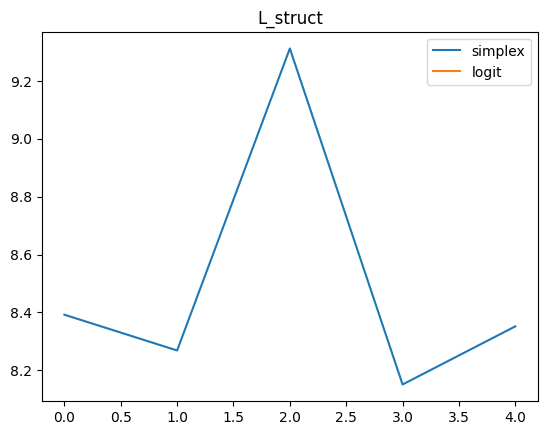

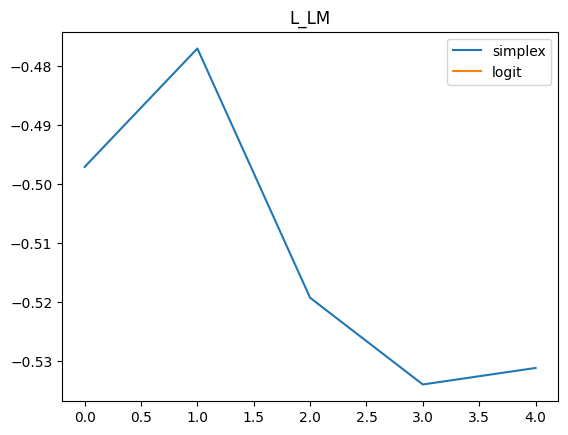

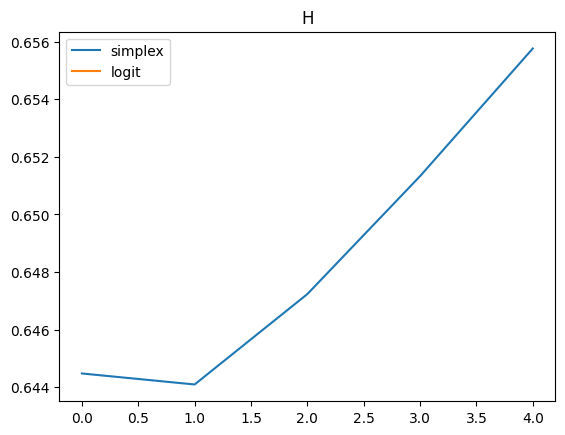

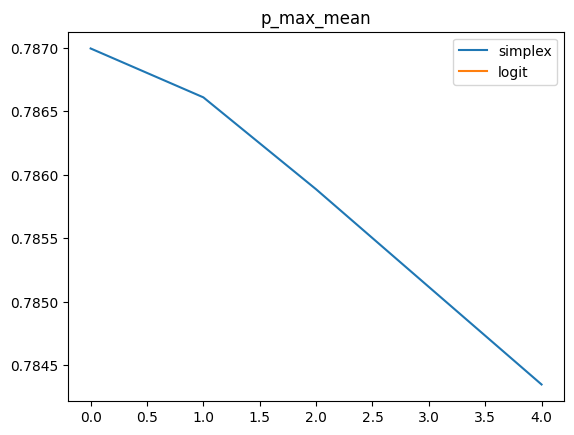

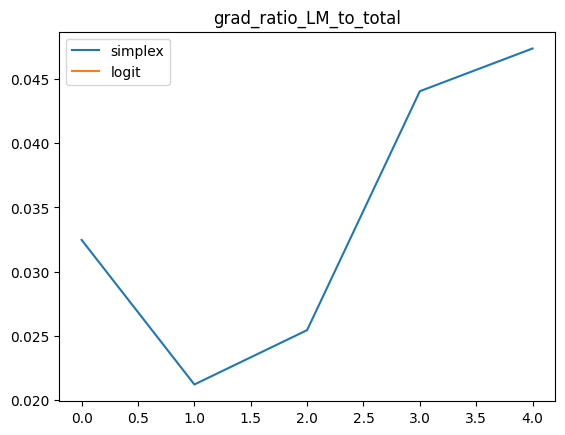

In [51]:
import pandas as pd
df = pd.DataFrame(log_simplex)
df.tail()

import matplotlib.pyplot as plt

for metric in ["L_struct", "L_LM", "H", "p_max_mean", "grad_ratio_LM_to_total"]:
    plt.figure()
    for arm in ["simplex", "logit"]:
        d = df[df.arm == arm]
        plt.plot(d.step, d[metric], label=arm)
    plt.title(metric)
    plt.legend()
    plt.show()

